In [33]:
import os
import copy
import pickle
import numpy as np
import glob

# matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# astropy
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.coordinates import SkyCoord, Angle
from astropy import wcs
from astropy.table import Table,vstack
import astropy.units as u
import matplotlib.pyplot as plt 


import sys
# so can find module one dir back; don't need to explicitly put .py into each subfolder 
sys.path.append("..")
from candels_galaxy_surveys import galaxy_catalog,galaxy_survey
import update_galaxy_survey

These pickles are for the supernova of HST catalog. They are lists, each item in list is another 3 element list for a given supernova. The elements being... 

1: table identifying supernova

2: survey for nearby to host

3: the host (more specifically it is the nearest function on the nearby which returns list of: [survey for host, ell radii host, other nearby ell radii])

Each is about 10 MB; I'll try to push that to github see if it is okay with storing them.

In [34]:
candels_Ias = pickle.load(open('host_data/candels_Ias.pkl','rb'))
candels_CCs = pickle.load(open('host_data/candels_CCs.pkl','rb'))
candels_SNs = pickle.load(open('host_data/candels_SNs.pkl','rb')) # type unknown 
goods_Ias = pickle.load(open('host_data/goods_Ias.pkl','rb'))
goods_CCs = pickle.load(open('host_data/goods_CCs.pkl','rb'))

Note the supernova for candels are classified just using the PIaz in table. At the moment unknown is 0.75>PIa>0.25

The supernova for goods have type in table for each. 

No new classifications based on my own lightcurve fitting, just using results given from initial data.

Next cell uses the host from these pickles gets parameters  (age, mass, sfr, and redshift) for the different types.

Puts the list of values for each into 4 element list. 1~Ia, 2~CC, 3~Unsure, 4~All the SN

Should make note that the age, mass, and sfr are for the '2a_tau' method where tau is another available parameter in the survey tables. My guess is tau is some decay parameter to an assumed exponential decay for the galaxies star formation history. 

The exact meaning of the method and tau however remain unclear despite my searching all of the read mes where these data come from. Need/would like to find precise definition of this method and difference from all the others available in survey table. 

In [35]:
# These are the host galaxies...
zs = [[],[],[],[]]# Ia, CC, unsure, All
# 2a_tau
ages = [[],[],[],[]] # Ia, CC, unsure, All
masses = [[],[],[],[]]
sfr = [[],[],[],[]]

# Ia hosts
for i in range(len(candels_Ias)):
    
    # don't know why I named it cat it is the host survey
    cat = candels_Ias[i][-1][0] 
    
    # goods-n has slightly different table structure than all the others
    # need this slightly annoying check
    if cat.source != 'Skelton14; goods-n_3dhst; https://3dhst.research.yale.edu/Data.php':
        #print(i,cat.source)
        zs[0].append(cat.mass[cat.redshift_names])
        masses[0].append(cat.mass[cat.mass_2a_tau])
        ages[0].append(cat.physpar[cat.age_2a_tau])
        sfr_val = cat.physpar[cat.sfr_2a_tau] 
        # I want sfr for all to be in log(solmass/yr) ie dex where is just order of mag solmass/yr
        sfr_val = np.log10(sfr_val) 
        sfr[0].append(sfr_val)
    elif cat.source == 'Skelton14; goods-n_3dhst; https://3dhst.research.yale.edu/Data.php':
        zs[0].append(cat.mass[cat.redshift_names])
        masses[0].append(cat.mass[cat.lmass])
        ages[0].append(cat.mass[cat.lage])
        sfr[0].append(cat.mass[cat.lsfr])
        # If vice-versa ie decide I want solmass/yr rather dex(solmass/yr) I need this expression
        # print(cat.mass[cat.lsfr],10**np.float(cat.mass[cat.lsfr]))
    else: print('wtf?')

for i in range(len(goods_Ias)):
    
    cat = goods_Ias[i][-1][0] 
    
    if cat.source != 'Skelton14; goods-n_3dhst; https://3dhst.research.yale.edu/Data.php':
        zs[0].append(cat.mass[cat.redshift_names])
        masses[0].append(cat.mass[cat.mass_2a_tau])
        ages[0].append(cat.physpar[cat.age_2a_tau])
        sfr_val = cat.physpar[cat.sfr_2a_tau] 
        sfr_val = np.log10(sfr_val) 
        sfr[0].append(sfr_val)
    elif cat.source == 'Skelton14; goods-n_3dhst; https://3dhst.research.yale.edu/Data.php':
        zs[0].append(cat.mass[cat.redshift_names])
        masses[0].append(cat.mass[cat.lmass])
        ages[0].append(cat.mass[cat.lage])
        sfr[0].append(cat.mass[cat.lsfr])
    else: print('wtf?')   
        
# Core collapse hosts
for i in range(len(candels_CCs)):
    
    cat = candels_CCs[i][-1][0] 
    
    if cat.source != 'Skelton14; goods-n_3dhst; https://3dhst.research.yale.edu/Data.php':
        zs[1].append(cat.mass[cat.redshift_names])
        masses[1].append(cat.mass[cat.mass_2a_tau])
        ages[1].append(cat.physpar[cat.age_2a_tau])
        sfr_val = cat.physpar[cat.sfr_2a_tau] 
        sfr_val = np.log10(sfr_val) 
        sfr[1].append(sfr_val)
    elif cat.source == 'Skelton14; goods-n_3dhst; https://3dhst.research.yale.edu/Data.php':
        zs[1].append(cat.mass[cat.redshift_names])
        masses[1].append(cat.mass[cat.lmass])
        ages[1].append(cat.mass[cat.lage])
        sfr[1].append(cat.mass[cat.lsfr])
    else: print('wtf?')

for i in range(len(goods_CCs)):
    
    cat = goods_CCs[i][-1][0]
    
    if cat.source != 'Skelton14; goods-n_3dhst; https://3dhst.research.yale.edu/Data.php':
        zs[1].append(cat.mass[cat.redshift_names])
        masses[1].append(cat.mass[cat.mass_2a_tau])
        ages[1].append(cat.physpar[cat.age_2a_tau])
        sfr_val = cat.physpar[cat.sfr_2a_tau] 
        sfr_val = np.log10(sfr_val) 
        sfr[1].append(sfr_val)
    elif cat.source == 'Skelton14; goods-n_3dhst; https://3dhst.research.yale.edu/Data.php':
        zs[1].append(cat.mass[cat.redshift_names])
        masses[1].append(cat.mass[cat.lmass])
        ages[1].append(cat.mass[cat.lage])
        sfr[1].append(cat.mass[cat.lsfr])
    else: print('wtf?')   

# Unsure type sn hosts
for i in range(len(candels_SNs)):
    cat = candels_SNs[i][-1][0] 
    
    if cat.source != 'Skelton14; goods-n_3dhst; https://3dhst.research.yale.edu/Data.php':
        zs[2].append(cat.mass[cat.redshift_names])
        masses[2].append(cat.mass[cat.mass_2a_tau])
        ages[2].append(cat.physpar[cat.age_2a_tau])
        #sfr[2].append(cat.physpar[cat.sfr_2a_tau])
        sfr_val = cat.physpar[cat.sfr_2a_tau] 
        sfr_val = np.log10(sfr_val) 
        sfr[2].append(sfr_val)
    elif cat.source == 'Skelton14; goods-n_3dhst; https://3dhst.research.yale.edu/Data.php':
        zs[2].append(cat.mass[cat.redshift_names])
        masses[2].append(cat.mass[cat.lmass])
        ages[2].append(cat.mass[cat.lage])
        sfr[2].append(cat.mass[cat.lsfr])
    else: print('wtf?')

/Users/kyleoconnor/anaconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10
/Users/kyleoconnor/anaconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10
/Users/kyleoconnor/anaconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in log10


Making sure the host data is all floats and removing bad/unknown data in next cell

In [36]:
# Formatting data 

# all into floats
zs[0] = [np.float(i) for i in zs[0]]
masses[0] = [np.float(i) for i in masses[0]]
ages[0] = [np.float(i) for i in ages[0]]
sfr[0] = [np.float(i) for i in sfr[0]]

zs[1] = [np.float(i) for i in zs[1]]
masses[1] = [np.float(i) for i in masses[1]]
ages[1] = [np.float(i) for i in ages[1]]
sfr[1] = [np.float(i) for i in sfr[1]]

zs[2] = [np.float(i) for i in zs[2]]
masses[2] = [np.float(i) for i in masses[2]]
ages[2] = [np.float(i) for i in ages[2]]
sfr[2] = [np.float(i) for i in sfr[2]]

# filter out unknowns reported as -99.0 
masses[0] = list(filter(lambda a: a != -99.0, masses[0]))
masses[1] = list(filter(lambda a: a != -99.0, masses[1]))
masses[2] = list(filter(lambda a: a != -99.0, masses[2]))


ages[0] = list(filter(lambda a: a != -99.0, ages[0]))
ages[1] = list(filter(lambda a: a != -99.0, ages[1]))
ages[2] = list(filter(lambda a: a != -99.0, ages[2]))

sfr[0] = list(filter(lambda a: a != -99.0, sfr[0]))
sfr[1] = list(filter(lambda a: a != -99.0, sfr[1]))
sfr[2] = list(filter(lambda a: a != -99.0, sfr[2]))

# combine both types to put in all
zs[3] = zs[0] + zs[1] + zs[2]
masses[3] = masses[0] + masses[1] + masses[2]
ages[3] = ages[0] + ages[1] + ages[2]
sfr[3] = sfr[0] + sfr[1] + sfr[2]

Getting the redshift of the SN to see how well agrees with the hosts z
subtracting SN - Host redshift

In [72]:
# zs has the redshifts of host w/ sn
# want to look at the preliminary given z for the SN to see which disagree w my host
zSNs = [[],[],[],[]] # Ia, CC, ?, All
# Ia
for i in range(len(candels_Ias)):
    zSNs[0].append(candels_Ias[i][0]['zSN'])
for i in range(len(goods_Ias)):
    zSNs[0].append(goods_Ias[i][0]['z'])
zSNs[0] = [np.float(i) for i in zSNs[0]]

# CC
for i in range(len(candels_CCs)):
    zSNs[1].append(candels_CCs[i][0]['zSN'])
for i in range(len(goods_CCs)):
    zSNs[1].append(goods_CCs[i][0]['z'])
zSNs[1] = [np.float(i) for i in zSNs[1]]

# Unknown
for i in range(len(candels_SNs)):
    zSNs[2].append(candels_SNs[i][0]['zSN'])
zSNs[2] = [np.float(i) for i in zSNs[2]]

# All
zSNs[3] = zSNs[0] + zSNs[1] + zSNs[2]

dzs = []
for i in range(len(zs)):
    dzs.append(np.subtract(zSNs[i],zs[i]))

In [98]:
# gets index of any |dz| > 0.1 from all the SN. (in order cIa,gIa,cCC,gCC,c??)
idx = []
for i in range(len(dzs[3])):
    if np.abs(dzs[3][i]) > 0.1:
        idx.append(i)

discrepants = []
# put the sn catalog list together in order to draw these discrepants from using idx
full = candels_Ias+goods_Ias+candels_CCs+goods_CCs+candels_SNs
for i in idx:
    discrepants.append([full[i],[zSNs[3][i],zs[3][i],dzs[3][i]]])

pickle.dump(discrepants,open('host_data/discrepant_host.pkl','wb'))

Text(0.5, 1.0, 'SN - Host Redshift')

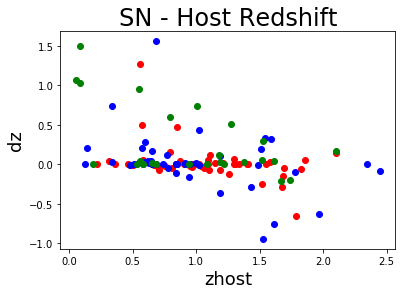

In [78]:
plt.plot(zs[0],dzs[0],'o',label='Ia',color='red')
plt.plot(zs[1],dzs[1],'o',label='CC',color='blue')
plt.plot(zs[2],dzs[2],'o',label='Unknown',color='green')
plt.ylabel('dz',size=18)
plt.xlabel('zhost',size=18)
plt.title('SN - Host Redshift',size=24)

The next two cells are doing similar (retrieving/formatting) the parameters for all of the galaxies in each field so we have some average to compare any host shifts to.

You will need the survey pickles of each field in my galaxy_data folder which is too large to store on github but I can provide.

In [31]:
# These are for all galaxies in catalog so can have reference for shifts of hosts
# Data needed is field pickles in galaxy_data folder

cats = ['cos','uds','goodss','egs','goodsn']
gc = galaxy_catalog(cats)

# make sure the surveys are up to date
gc.cos = update_galaxy_survey.update_survey(gc.cos)
gc.egs = update_galaxy_survey.update_survey(gc.egs)
gc.goodss = update_galaxy_survey.update_survey(gc.goodss)
gc.uds = update_galaxy_survey.update_survey(gc.uds)
gc.goodsn = update_galaxy_survey.update_survey(gc.goodsn)

# Getting parameters for all the galaxies in each field
zcos = [np.float(i) for i in gc.cos.mass[gc.cos.redshift_names]]
zegs = [np.float(i) for i in gc.egs.mass[gc.egs.redshift_names]]
zgoodss = [np.float(i) for i in gc.goodss.mass[gc.goodss.redshift_names]]
zuds = [np.float(i) for i in gc.uds.mass[gc.uds.redshift_names]]
zgoodsn = [np.float(i) for i in gc.goodsn.mass[gc.goodsn.redshift_names]]

mcos = [np.float(i) for i in gc.cos.mass[gc.cos.mass_2a_tau]]
megs = [np.float(i) for i in gc.egs.mass[gc.egs.mass_2a_tau]]
mgoodss = [np.float(i) for i in gc.goodss.mass[gc.goodss.mass_2a_tau]]
muds = [np.float(i) for i in gc.uds.mass[gc.uds.mass_2a_tau]]
mgoodsn = [np.float(i) for i in gc.goodsn.mass[gc.goodsn.lmass]]


# Word of caution 
# goods-n is the outlier; the catalogs aren't as similar as they are for the other fields
# for example the next two parameters are in a different catalog for goods-n from the others 
# if you look at script the table for each parameter is available if have any questions
agecos = [np.float(i) for i in gc.cos.physpar[gc.cos.age_2a_tau]]
ageegs = [np.float(i) for i in gc.egs.physpar[gc.egs.age_2a_tau]]
agegoodss = [np.float(i) for i in gc.goodss.physpar[gc.goodss.age_2a_tau]]
ageuds = [np.float(i) for i in gc.uds.physpar[gc.uds.age_2a_tau]]
agegoodsn = [np.float(i) for i in gc.goodsn.mass[gc.goodsn.lage]]

sfrcos = [np.float(i) for i in gc.cos.physpar[gc.cos.sfr_2a_tau]]
sfregs = [np.float(i) for i in gc.egs.physpar[gc.egs.sfr_2a_tau]]
sfrgoodss = [np.float(i) for i in gc.goodss.physpar[gc.goodss.sfr_2a_tau]]
sfruds = [np.float(i) for i in gc.uds.physpar[gc.uds.sfr_2a_tau]]
sfrgoodsn = [np.float(i) for i in gc.goodsn.mass[gc.goodsn.lsfr]]

# If gc.field returns a list need to index
"""
zcos = [np.float(i) for i in gc.cos[0].mass[gc.cos[0].redshift_names]]
zegs = [np.float(i) for i in gc.egs[0].mass[gc.egs[0].redshift_names]]
zgoodss = [np.float(i) for i in gc.goodss[0].mass[gc.goodss[0].redshift_names]]
zuds = [np.float(i) for i in gc.uds[0].mass[gc.uds[0].redshift_names]]
zgoodsn = [np.float(i) for i in gc.goodsn[0].mass[gc.goodsn[0].redshift_names]]

mcos = [np.float(i) for i in gc.cos[0].mass[gc.cos[0].mass_2a_tau]]
megs = [np.float(i) for i in gc.egs[0].mass[gc.egs[0].mass_2a_tau]]
mgoodss = [np.float(i) for i in gc.goodss[0].mass[gc.goodss[0].mass_2a_tau]]
muds = [np.float(i) for i in gc.uds[0].mass[gc.uds[0].mass_2a_tau]]
mgoodsn = [np.float(i) for i in gc.goodsn[0].mass[gc.goodsn[0].lmass]]


# Word of caution 
# goods-n is the outlier; the catalogs aren't as similar as they are for the other fields
# for example the next two parameters are in a different catalog for goods-n from the others 
# if you look at script the table for each parameter is available if have any questions
agecos = [np.float(i) for i in gc.cos[0].physpar[gc.cos[0].age_2a_tau]]
ageegs = [np.float(i) for i in gc.egs[0].physpar[gc.egs[0].age_2a_tau]]
agegoodss = [np.float(i) for i in gc.goodss[0].physpar[gc.goodss[0].age_2a_tau]]
ageuds = [np.float(i) for i in gc.uds[0].physpar[gc.uds[0].age_2a_tau]]
agegoodsn = [np.float(i) for i in gc.goodsn[0].mass[gc.goodsn[0].lage]]

sfrcos = [np.float(i) for i in gc.cos[0].physpar[gc.cos[0].sfr_2a_tau]]
sfregs = [np.float(i) for i in gc.egs[0].physpar[gc.egs[0].sfr_2a_tau]]
sfrgoodss = [np.float(i) for i in gc.goodss[0].physpar[gc.goodss[0].sfr_2a_tau]]
sfruds = [np.float(i) for i in gc.uds[0].physpar[gc.uds[0].sfr_2a_tau]]
sfrgoodsn = [np.float(i) for i in gc.goodsn[0].mass[gc.goodsn[0].lsfr]]
"""

"\nzcos = [np.float(i) for i in gc.cos[0].mass[gc.cos[0].redshift_names]]\nzegs = [np.float(i) for i in gc.egs[0].mass[gc.egs[0].redshift_names]]\nzgoodss = [np.float(i) for i in gc.goodss[0].mass[gc.goodss[0].redshift_names]]\nzuds = [np.float(i) for i in gc.uds[0].mass[gc.uds[0].redshift_names]]\nzgoodsn = [np.float(i) for i in gc.goodsn[0].mass[gc.goodsn[0].redshift_names]]\n\nmcos = [np.float(i) for i in gc.cos[0].mass[gc.cos[0].mass_2a_tau]]\nmegs = [np.float(i) for i in gc.egs[0].mass[gc.egs[0].mass_2a_tau]]\nmgoodss = [np.float(i) for i in gc.goodss[0].mass[gc.goodss[0].mass_2a_tau]]\nmuds = [np.float(i) for i in gc.uds[0].mass[gc.uds[0].mass_2a_tau]]\nmgoodsn = [np.float(i) for i in gc.goodsn[0].mass[gc.goodsn[0].lmass]]\n\n\n# Word of caution \n# goods-n is the outlier; the catalogs aren't as similar as they are for the other fields\n# for example the next two parameters are in a different catalog for goods-n from the others \n# if you look at script the table for each paramet

In [ ]:
# filter unknowns... -99.0
mcos = list(filter(lambda a: a != -99.0, mcos))
megs = list(filter(lambda a: a != -99.0, megs))
mgoodss = list(filter(lambda a: a != -99.0, mgoodss))
muds = list(filter(lambda a: a != -99.0, muds))
mgoodsn = list(filter(lambda a: a != -99.0, mgoodsn))

agecos = list(filter(lambda a: a != -99.0, agecos))
ageegs = list(filter(lambda a: a != -99.0, ageegs))
agegoodss = list(filter(lambda a: a != -99.0, agegoodss))
ageuds = list(filter(lambda a: a != -99.0, ageuds))
agegoodsn = list(filter(lambda a: a != -99.0, agegoodsn))

sfrcos = list(filter(lambda a: a != -99.0, sfrcos))
sfregs = list(filter(lambda a: a != -99.0, sfregs))
sfrgoodss = list(filter(lambda a: a != -99.0, sfrgoodss))
sfruds = list(filter(lambda a: a != -99.0, sfruds))
sfrgoodsn = list(filter(lambda a: a != -99.0, sfrgoodsn))

# taking out sfr = 0 msol/yr (~dead dormant galaxies) in goods-s and uds so log10 -> dex(msolar)/yr doesn't -inf explode
sfruds = list(filter(lambda a: a != 0, sfruds))
sfrgoodss = list(filter(lambda a: a != 0, sfrgoodss))


# changing sfr for all but goodsn; want them to be in dex(solar mass)/yr rather than just solar mass/yr
sfrcos = [np.log10(i) for i in sfrcos]
sfregs = [np.log10(i) for i in sfregs]
sfruds = [np.log10(i) for i in sfruds]
sfrgoodss = [np.log10(i) for i in sfrgoodss]

# combine to get full 
zall = zcos + zegs + zgoodss + zuds + zgoodsn
mall = mcos + megs + mgoodss + muds + mgoodsn
ageall = agecos + ageegs + agegoodss + ageuds + agegoodsn
sfrall = sfrcos + sfregs + sfrgoodss + sfruds + sfrgoodsn

In [ ]:
import seaborn as sns
from scipy.stats import norm                                                  
plt.hist(sfr[0],color='r',label='Ia',alpha = 0.5,density=True)
plt.hist(sfr[1],color='b',label='CC',alpha=0.5,density=True)
#plt.hist(sfr[3],color='green',label='All SN',alpha = 0.3,normed=True)

plt.xlabel('dex($M_\odot$)/yr',size='18')
plt.legend()
plt.title('Host SFRs',size=24)


sns.distplot(sfrall, hist=False, kde=True, 
             bins=int(180/5), label='All Gal',color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
sns.distplot(sfr[3], hist=False, kde=True, 
             bins=int(180/5), label='All SN',color = 'green', 
             hist_kws={'edgecolor':'green'},
             kde_kws={'linewidth': 4})
plt.xlim(-10,3)
#plt.show()
plt.savefig('images/HostSfr',bbox_inches='tight')

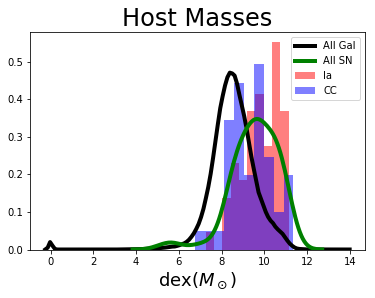

In [41]:
plt.hist(masses[0],color='r',label='Ia',alpha = 0.5,density=True)
plt.hist(masses[1],color='b',label='CC',alpha=0.5,density=True)
#plt.hist(sfr[3],color='green',label='All SN',alpha = 0.3,normed=True)

plt.xlabel('dex($M_\odot$)',size='18')
plt.legend()
plt.title('Host Masses',size=24)


sns.distplot(mall, hist=False, kde=True, 
             bins=int(180/5), label='All Gal',color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
sns.distplot(masses[3], hist=False, kde=True, 
             bins=int(180/5), label='All SN',color = 'green', 
             hist_kws={'edgecolor':'green'},
             kde_kws={'linewidth': 4})
#plt.xlim(-10,3)
#plt.show()
plt.savefig('images/HostsMass',bbox_inches='tight')

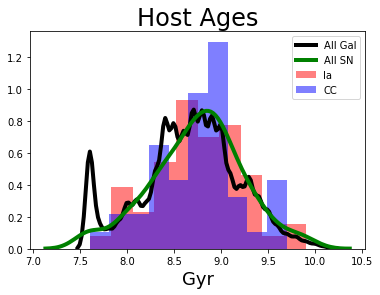

In [42]:
plt.hist(ages[0],color='r',label='Ia',alpha = 0.5,density=True)
plt.hist(ages[1],color='b',label='CC',alpha=0.5,density=True)
#plt.hist(sfr[3],color='green',label='All SN',alpha = 0.3,normed=True)

plt.xlabel('Gyr',size='18')
plt.legend()
plt.title('Host Ages',size=24)


sns.distplot(ageall, hist=False, kde=True, 
             bins=int(180/5), label='All Gal',color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
sns.distplot(ages[3], hist=False, kde=True, 
             bins=int(180/5), label='All SN',color = 'green', 
             hist_kws={'edgecolor':'green'},
             kde_kws={'linewidth': 4})
#plt.xlim(-10,3)
#plt.show()
plt.savefig('images/HostAges',bbox_inches='tight')

Also nice to plot parameters of the hosts as functions of redshift. Need to make sure the redshift and parameter list are same length though, that means deleting any host which has an unknown value for either.  

In [52]:
# to plot parameters vs redshift we need to get rid of any host which has unknown values; need them same length
# reinitialize the unfiltered data for the hosts, will filter  a little differently now
# ie go back up to top of nb and rerun 3rd code cell; the one starting with comment 'These are the host galaxies...'

print('Looking for unknown data need to remove to plot vs redshift...')
print('Ias')
for i in range(len(masses[0])):
    if masses[0][i] == -99.0:
        print('mass unknown')
        print(i,masses[0][i])
    if ages[0][i] == -99.0:
        print('age unknown')
        print(i,ages[0][i])
    if sfr[0][i] == -99.0:
        print('sfr unknown')
        print(i,sfr[0][i])
print('CCs')
for i in range(len(masses[1])):
    if masses[1][i] == -99.0:
        print('mass unknown')
        print(i,masses[1][i])
    if ages[1][i] == -99.0:
        print('age unknown')
        print(i,ages[1][i])
    if sfr[1][i] == -99.0:
        print('sfr unknown')
        print(i,sfr[1][i])
print('Unsure on types')
for i in range(len(masses[2])):
    if masses[2][i] == -99.0:
        print('mass unknown')
        print(i,masses[2][i])
    if ages[2][i] == -99.0:
        print('age unknown')
        print(i,ages[2][i])
    if sfr[2][i] == -99.0:
        print('sfr unknown')
        print(i,sfr[2][i])
        
indexes0 = [12,53]
for index in sorted(indexes0, reverse=True):
    del masses[0][index]
    del ages[0][index]
    del sfr[0][index]
    del zs[0][index]
indexes2 = [18]
for index in sorted(indexes2, reverse=True):
    del masses[2][index]
    del ages[2][index]
    del sfr[2][index]
    del zs[2][index]

masses[-1] = masses[0] + masses[1] + masses[2]
ages[-1] = ages[0] + ages[1] + ages[2]
sfr[-1] = sfr[0] + sfr[1] + sfr[2]
zs[-1] = zs[0] + zs[1] + zs[2]

masses[-1] = [np.float(i) for i in masses[-1]]
zs[-1] = [np.float(i) for i in zs[-1]]
ages[-1] = [np.float(i) for i in ages[-1]]
sfr[-1] = [np.float(i) for i in sfr[-1]]

masses[0] = [np.float(i) for i in masses[0]]
zs[0] = [np.float(i) for i in zs[0]]
ages[0] = [np.float(i) for i in ages[0]]
sfr[0] = [np.float(i) for i in sfr[0]]

masses[1] = [np.float(i) for i in masses[1]]
zs[1] = [np.float(i) for i in zs[1]]
ages[1] = [np.float(i) for i in ages[1]]
sfr[1] = [np.float(i) for i in sfr[1]]

masses[2] = [np.float(i) for i in masses[2]]
zs[2] = [np.float(i) for i in zs[2]]
ages[2] = [np.float(i) for i in ages[2]]
sfr[2] = [np.float(i) for i in sfr[2]]

Looking for unknown data need to remove to plot vs redshift...
Ias
mass unknown
12 -99.0
age unknown
12 -99.0
mass unknown
53 -99.0
age unknown
53 -99.0
CCs
Unsure on types
mass unknown
18 -99.0
age unknown
18 -99.0


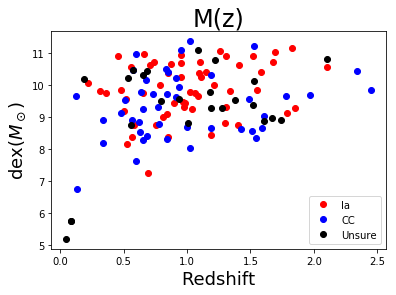

In [53]:
fig,ax = plt.subplots(1)

ax.plot(zs[0],masses[0],'o',color='red',label='Ia')
ax.plot(zs[1],masses[1],'o',color='blue',label='CC')
ax.plot(zs[2],masses[2],'o',color='black',label='Unsure')
ax.set_xlabel('Redshift',size=18)
ax.set_ylabel('dex($M_\odot$)',size=18)
plt.legend()
plt.title('M(z)',size=24)
plt.savefig('MassZ')
#ax.set_yticklabels([8,9,10])
#ax.set_xticklabels([])

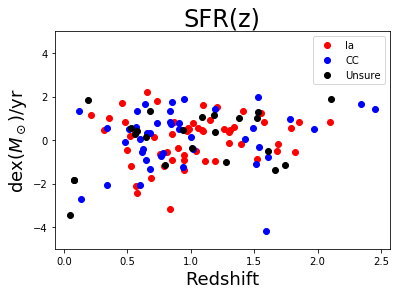

In [54]:
# Create Figure and Axes instances
fig,ax = plt.subplots(1)

# Make your plot, set your axes labels
ax.plot(zs[0],sfr[0],'o',color='red',label='Ia')
ax.plot(zs[1],sfr[1],'o',color='blue',label='CC')
ax.plot(zs[2],sfr[2],'o',color='black',label='Unsure')
ax.set_xlabel('Redshift',size=18)
ax.set_ylabel('dex($M_\odot$)/yr',size=18)
plt.legend()
plt.title('SFR(z)',size=24)
plt.ylim(-5,5)
plt.savefig('SFRz')
#ax.set_yticklabels([8,9,10])
#ax.set_xticklabels([])

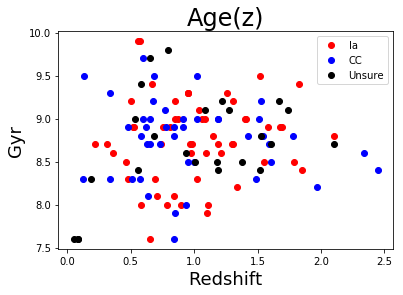

In [55]:
# Create Figure and Axes instances
fig,ax = plt.subplots(1)

# Make your plot, set your axes labels
ax.plot(zs[0],ages[0],'o',color='red',label='Ia')
ax.plot(zs[1],ages[1],'o',color='blue',label='CC')
ax.plot(zs[2],ages[2],'o',color='black',label='Unsure')
ax.set_xlabel('Redshift',size=18)
ax.set_ylabel('Gyr',size=18)
plt.legend()
#plt.axhline(y=np.nanmean(ageall), color='gold', linestyle='-',label='mean all gals')
plt.title('Age(z)',size=24)
plt.savefig('AgeZ')